In [77]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json

%matplotlib inline

In [80]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

# Tensorflow

In [ ]:
model = tf.keras.models.load_model('../models/affectnet_emotions/mobilenet_7.h5', compile=False)
model.summary()


Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_pad (ZeroPadding2D)       │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,493,063 (13.32 MB)

 Trainable params: 3,471,175 (13.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [82]:
def mobilenet_preprocess_input(x,**kwargs):
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x
preprocessing_function=mobilenet_preprocess_input
INPUT_SIZE = (224, 224)

In [ ]:
#감정 라벨
data_classes={'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happiness': 3, 'Neutral': 4, 'Sadness': 5, 'Surprise': 6}
idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}

# 정답 레이블
ans = []
# 예측 레이블
pred = []

In [ ]:
# picture 폴더 경로
picture_dir='C:/baekjoon_Git_repository/face-emotion-recognition/training_and_examples/picture'

# 결과 저장할 폴더
save_dir = "./grad-cam_picture/korean/neutral/"

In [ ]:
for fname in os.listdir(picture_dir):
    if fname.endswith('.jpg'):
        fpath = os.path.join(picture_dir, fname)
        fpath = fpath.encode('utf-8').decode('utf-8')

        frame_bgr = cv2.imread(fpath)
        if frame_bgr is None:
            print(f"이미지 로딩 안됨: {fpath}")
            continue

        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        bounding_boxes, points = imgProcessing.detect_faces(frame)
        points = points.T

        if len(bounding_boxes) == 0:
            print(f"얼굴 감지 안됨: {fname}")
            continue
        box = bounding_boxes[0].astype(int)
        x1, y1, x2, y2 = box[0:4]

        if x2 <= x1 or y2 <= y1:
            print(f"잘못된 bounding box 좌표: {fname}")
            continue

        face_img = frame[y1:y2, x1:x2, :]
        if face_img.size == 0:
            print(f"얼굴 크기 오류: {fname} (x1={x1}, y1={y1}, x2={x2}, y2={y2})")
            continue

        face_img = cv2.resize(face_img, INPUT_SIZE)
        inp = face_img.astype(np.float32)
        inp[..., 0] -= 103.939
        inp[..., 1] -= 116.779
        inp[..., 2] -= 123.68
        inp = np.expand_dims(inp, axis=0)

        scores = model.predict(inp)[0]
        predicted_label = int(np.argmax(scores))

        emotion = fname.split('_')[3]
        print(emotion)

        if emotion in data_classes:
            correct_label = data_classes[emotion]

            ans.append(correct_label)
            pred.append(predicted_label)

            print(f"예측 레이블: {predicted_label}, 정답 레이블: {correct_label}")

        else:
            print(f"정답 레이블을 찾을 수 없음: {emotion}")
            continue

print("정답 레이블:", ans)
print("예측 레이블:", pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Sadness
예측 레이블: 5, 정답 레이블: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Neutral
예측 레이블: 5, 정답 레이블: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Anger
예측 레이블: 6, 정답 레이블: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Surprise
예측 레이블: 6, 정답 레이블: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Anger
예측 레이블: 1, 정답 레이블: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Disgust
예측 레이블: 5, 정답 레이블: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Fear
예측 레이블: 2, 정답 레이블: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Surprise
예측 레이블: 6, 정답 레이블: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Surprise
예측 레이블: 6, 정답 레이블: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Surprise
예측 레이블: 2, 정답 레이블: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Fear
예측 레이블: 2, 정답 레이블: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Fear
예측 레이블: 2, 정답 레이블: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Fear
예측 레이블: 4, 정답 레이블: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Happiness
예측 레이블: 3, 정답 레이블: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Sadness
예측 레이블: 1, 정답 레이블: 5
1/1 

In [ ]:
from sklearn.metrics import confusion_matrix

#혼동행렬
cm = confusion_matrix(ans, pred)

#정확도계산 (TP + TN) / (TP + TN + FP + FN)
accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.40


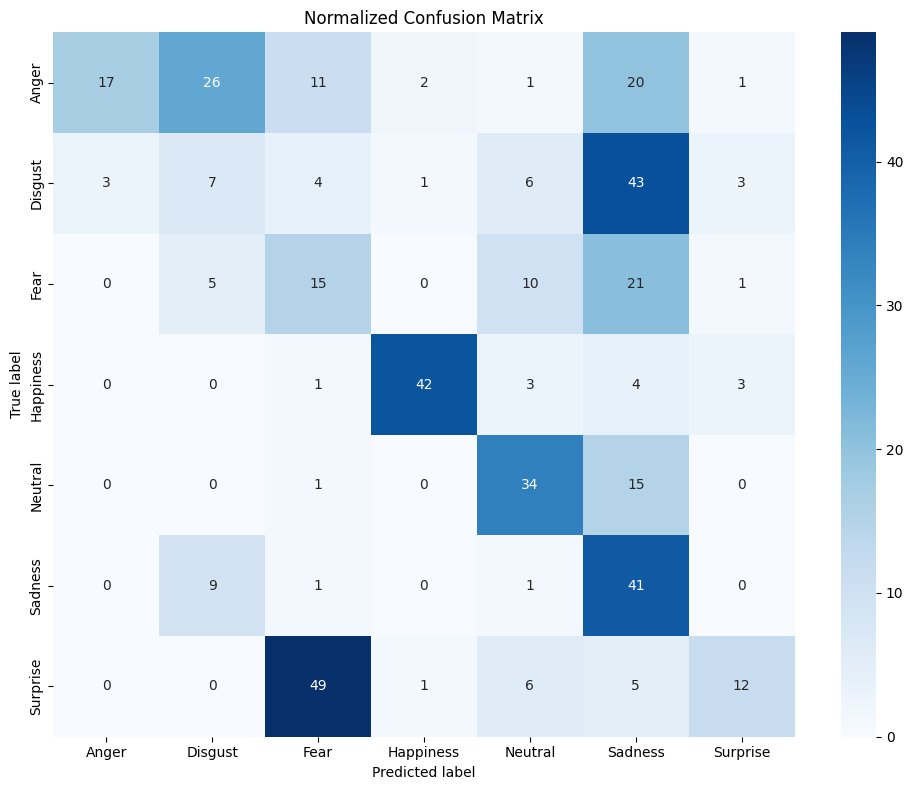

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


idx_to_class = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}

#혼동행렬 출력
cm = confusion_matrix(ans, pred)

class_labels = [idx_to_class[i] for i in range(len(idx_to_class))]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score
import numpy as np

# 클래스별 정밀도 계산
precision_per_class = precision_score(ans, pred, average=None)
emotion_labels = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}

for class_id, precision in enumerate(precision_per_class):
    emotion = emotion_labels.get(class_id, f"Class {class_id}")
    print(f"{emotion}: {precision:.4f}")


Anger: 0.8500
Disgust: 0.1489
Fear: 0.1829
Happiness: 0.9130
Neutral: 0.5574
Sadness: 0.2752
Surprise: 0.6000
